In [2]:
import numpy as np
import trimesh
import scipy
import matplotlib.pyplot as plt
import scipy.sparse as sparse

In [13]:
def cotangent_weights(vertices, faces):
    """
    Compute the cotengenant weights matrix for mesh laplacian.
    Entry (i,i) is 1/6 of the sum of the area of surrounding triangles
    Entry (i,j) is 1/12 of the sum of the area of triangles using edge (i,j)
    Parameters
    -----------------------------
    vertices   : (n,3) array of vertices coordinates
    faces      : (m,3) array of vertex indices defining faces
    faces_area : (m,) - Optional, array of per-face area
    Output
    -----------------------------
    A : (n,n) sparse area matrix
    """
    N = vertices.shape[0]

    v1 = vertices[faces[:,0]]  # (m,3)
    v2 = vertices[faces[:,1]]  # (m,3)
    v3 = vertices[faces[:,2]]  # (m,3)

    # Edge lengths indexed by opposite vertex
    u1 = v3 - v2
    u2 = v1 - v3
    u3 = v2 - v1

    L1 = np.linalg.norm(u1,axis=1)  # (m,)
    L2 = np.linalg.norm(u2,axis=1)  # (m,)
    L3 = np.linalg.norm(u3,axis=1)  # (m,)

    # Compute cosine of angles
    A1 = np.einsum('ij,ij->i', -u2, u3) / (L2*L3)  # (m,)
    A2 = np.einsum('ij,ij->i', u1, -u3) / (L1*L3)  # (m,)
    A3 = np.einsum('ij,ij->i', -u1, u2) / (L1*L2)  # (m,)

    # Use cot(arccos(x)) = x/sqrt(1-x^2)
    I = np.concatenate([faces[:,0], faces[:,1], faces[:,2]])
    J = np.concatenate([faces[:,1], faces[:,2], faces[:,0]])
    S = np.concatenate([A3,A1,A2])
    S = 0.5 * S / np.sqrt(1-S**2)

    In = np.concatenate([I, J, I, J])
    Jn = np.concatenate([J, I, I, J])
    Sn = np.concatenate([-S, -S, S, S])
    W = sparse.coo_matrix((Sn, (In, Jn)), shape=(N, N)).tocsc()
    # print("Sn: ",Sn)
    # print("W: ", W)
    # print("In: ", In)
    # print("IJn: ", Jn)
    return W


In [10]:
from scipy.sparse import coo_matrix, eye
from scipy.spatial import distance
def get_cotangent_weight(i,neighbor,neighbors,norms, KNN):
    def get_k_h(i,j):
        list1, list2 = neighbors[i], neighbors[j]
        #if there is morethan 2 intersection choose the first 2 points
        intersection = list(set(list1).intersection(list2))
        try:
            k,h = intersection
        except:
            k,h = intersection[:2]
            # print(intersection)
            # print(i,j)
            # print('k,h', )

        return k,h
    def get_distance(i,j,k,h):
        j_idx = neighbors[i].index(j)
        lij = norms[i][j_idx]

        k_idx = neighbors[j].index(k)
        ljk = norms[j][k_idx]

        i_idx = neighbors[k].index(i)
        lki = norms[k][i_idx]

        h_idx = neighbors[j].index(h)
        ljh = norms[j][h_idx]

        i_idx = neighbors[h].index(i)
        lhi = norms[h][i_idx]

        return lij, ljk, lki, ljh, lhi 

    result = []
    for j in KNN:
        #if j in neighbor find Cotangent weight else assign 0
        wij = 0
        if j in neighbor:
            
            k,h  = get_k_h(i,j)
            lij, ljk, lki, ljh, lhi = get_distance(i,j,k,h)

            s_ijk = (lij + ljk + lki)/2
            A_ijk = 8 *  np.sqrt(s_ijk * ( s_ijk - lij) * ( s_ijk- ljk) * ( s_ijk - lki))

            s_ijh = (lij + ljh + lhi)/2
            A_ijh = 8 *  np.sqrt(s_ijh * ( s_ijh - lij) * ( s_ijh- ljh) * ( s_ijh - lhi))

            
            wij = ((-lij**2 + ljk ** 2 + lki**2)/  A_ijk)  + ((-lij**2 + ljh ** 2 + lhi**2)/  A_ijh)
        
       
        result.append(wij)
        
    return result

def knn_cotangent_laplacian(mesh, k):
    neighbors = mesh.vertex_neighbors
    
    vertices = mesh.vertices.view(np.ndarray)

    ones = np.ones(3)
    norms = [np.sqrt(np.dot((vertices[i] - vertices[n]) ** 2, ones))
                for i, n in enumerate(neighbors)]
    D = distance.squareform(distance.pdist(vertices))
    closest = np.argsort(D, axis=1)
    closest = closest[:, 1:k+1]



    # norms = [i / i.sum() for i in norms]
    data = []

    for i, KNN in enumerate(closest):
        neighbor = neighbors[i]
        weight = get_cotangent_weight(i,neighbor, neighbors,norms, KNN)
        data.append(weight)
        # create the sparse matrix
    
    col = np.concatenate(closest)
    row = np.concatenate([[i] * len(n)
                          for i, n in enumerate(closest)])
    
   
    # data = np.concatenate([i / np.array(i).sum() if np.array(i).sum()>0 else i for i in data])
    # data = np.concatenate([i if np.array(i).sum()>0 else i for i in data])
    
    
    # matrix = coo_matrix((data, (row,col)),
    #                     shape=[len(vertices)] * 2)
    return data
human_mesh = trimesh.load_mesh("data/experiments/meshes_squat1_mesh_0010.obj")
knn_laplace = knn_cotangent_laplacian(human_mesh, 6)
print(knn_laplace)

In [14]:
cotan_laplacian = cotangent_weights(np.array(L_origial.vertices), np.array(L_origial.faces))
cotan_laplacian = cotan_laplacian.tocsr()
print(cotan_laplacian)

  (0, 0)	5.013902557398921
  (0, 1)	-1.007854
  (0, 2)	-1.1239036320069773
  (0, 3)	-0.952732
  (0, 5)	-0.0
  (0, 6)	-0.9448779999999999
  (0, 7)	-0.0
  (0, 12)	-0.9845349253919434
  (0, 13)	-0.0
  (1, 0)	-1.007854
  (1, 1)	4.000242925391944
  (1, 4)	-1.007854
  (1, 7)	-0.9999999999999999
  (1, 13)	-0.9845349253919434
  (1, 15)	-0.0
  (2, 0)	-1.1239036320069773
  (2, 2)	3.013659632006977
  (2, 5)	-0.9448779999999999
  (2, 6)	-0.0
  (2, 8)	-0.9448779999999999
  (2, 11)	-0.0
  (3, 0)	-0.952732
  (3, 3)	5.013902557398921
  (3, 4)	-1.007854
  (3, 5)	-1.1239036320069773
  :	:
  (11, 8)	-0.9448779999999999
  (11, 9)	-1.1239036320069773
  (11, 11)	3.013659632006977
  (12, 0)	-0.9845349253919434
  (12, 3)	-0.0
  (12, 12)	3.0002429253919436
  (12, 13)	-1.007854
  (12, 14)	-1.007854
  (13, 0)	-0.0
  (13, 1)	-0.9845349253919434
  (13, 12)	-1.007854
  (13, 13)	3.0002429253919436
  (13, 14)	-0.0
  (13, 15)	-1.007854
  (14, 3)	-0.9845349253919434
  (14, 4)	-0.0
  (14, 12)	-1.007854
  (14, 13)	-0.0
 

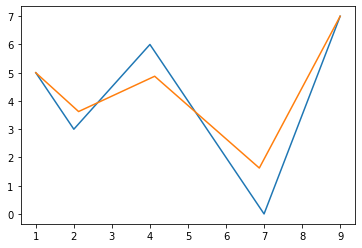

In [35]:
#smooth
x_new = x.copy()
y_new = y.copy()
for i in range(1,len(x)-1):
    Lx = (x[i+1]-x[i])/2 + (x[i-1]-x[i])/2
    Ly = (y[i+1]-y[i])/2 + (y[i-1]-y[i])/2
    x_new[i] = x[i] + Lx/4
    y_new[i] = y[i] + Ly/4
plt.plot(x,y, label ="original")
plt.plot(x_new,y_new,label ="smoothed")
plt.show()

In [43]:
dy=np.diff(y,1)
dx=np.diff(x,1)
yfirst=dy/dx

xfirst=0.5*(x[:-1]+x[1:])

dyfirst=np.diff(yfirst,1)
dxfirst=np.diff(xfirst,1)
ysecond=dyfirst/dxfirst

xsecond=0.5*(xfirst[:-1]+xfirst[1:])

In [7]:
L_mesh = trimesh.load_mesh("data/experiments/L.obj")
L_origial = L_mesh.copy()
# L_smoothed = trimesh.smoothing.filter_taubin(L_mesh)
# L_smoothed.show()

In [5]:
#cotan smoothing
def post_process(matrix):
    result = []
    for i, row in enumerate(matrix):
        temp = [0.0] * len(row)    
        for j, item in enumerate(row):
            if j == i:
                continue
            temp[j] = abs(item)
        # temp = [(1.0 / np.maximum(1e-6,k)) for k in temp]
        temp = temp / np.sum(temp)
        result.append(temp)
    return result
cotan_laplacian = cotangent_weights(np.array(L_origial.vertices), np.array(L_origial.faces))
result = post_process(np.array(cotan_laplacian.toarray()))
# result

# print(cotan_laplacian)
# L_smoothed = trimesh.smoothing.filter_taubin(L_mesh, laplacian_operator=cotan_laplacian)
# L_smoothed.show()

In [56]:
a = [0.0, 1.007854, 1.1239036320069773, 0.952732, 0.0, 0.0, 0.9448779999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9845349253919434, 0.0, 0.0, 0.0]
b = a/np.sum(a)
np.sum(b)
# 1/1.007854

0.9999999999999999

In [3]:
import robust_laplacian
human_mesh = trimesh.load_mesh("data/experiments/meshes_squat1_mesh_0010.obj")

verts, faces = np.array(human_mesh.vertices), np.array(human_mesh.faces)
L, M = robust_laplacian.mesh_laplacian(verts, faces)
L_row = L.tocsr()
print(L_row)
def post_processing():
    for row in L_row:
        print(row.indices)
        break
def knn_cotan(mesh, k):
    def get_weight(neighbour,cotan_weight, i):
        indices = set(cotan_weight.getrow(i).indices)
        values = np.array(cotan_weight.getrow(i).todense())
        result = []
        for col in neighbour:
            if col in indices:
                result.append(values[0][col])
            else:
                result.append(0.0)
        return result
    vertices = mesh.vertices.view(np.ndarray)
    faces = mesh.faces.view(np.ndarray)
    L, M = robust_laplacian.mesh_laplacian(vertices, faces)
    cotan_weight = L.tocsr()
    D = distance.squareform(distance.pdist(vertices))
    closest = np.argsort(D, axis=1)
    closest = closest[:, 1:k+1]

    data = []
    for i, neighbour in enumerate(closest):
        weight = get_weight(neighbour, cotan_weight, i)
        # weight.extend([0.0]*(k-len(weight)))
        data.append(weight)
    
    
    col = np.concatenate(closest)
    row = np.concatenate([[i] * len(n)
                          for i, n in enumerate(closest)])
    
   
    # # data = np.concatenate([i / np.array(i).sum() if np.array(i).sum()>0 else i for i in data])
    data = np.concatenate([i for i in data])
    
    
    matrix = coo_matrix((data, (row,col)),
                        shape=[len(vertices)] * 2)
    return matrix
def create_target():
    files = glob.glob('data/noisy/*.obj')
    for file in files:
        print(file)
        mesh = trimesh.load_mesh(file)
        result = knn_cotan(mesh, 6)
    
        dest_name = 'data/laplacian/' +file.split('/')[-1].split('.')[0] +'.laplacian'
        # save_xyz(result, dest_name)
        break
# matrix = knn_cotan(human_mesh, k=6)
# matrix.shape

  (0, 0)	4.553863203801015
  (0, 2043)	-0.1381478860643397
  (0, 2667)	-1.9682966248266907
  (0, 5090)	-0.0897205231014159
  (0, 5536)	-1.2194884595317084
  (0, 9069)	-1.1382097102768602
  (1, 1)	4.10024469280101
  (1, 2162)	-0.7555791161403635
  (1, 3190)	-0.2266671786901439
  (1, 3290)	-1.0980354955194374
  (1, 5563)	-1.2238646944688045
  (1, 6232)	-0.5644099211415016
  (1, 7203)	-0.2316882868407589
  (2, 2)	4.6339816842498776
  (2, 1904)	-0.10129874502840841
  (2, 5019)	-0.8669819225023725
  (2, 6417)	-0.455299264014549
  (2, 7479)	-0.759370276884301
  (2, 9129)	-0.23868698871687694
  (2, 9257)	-2.2123444871033704
  (3, 3)	4.072886776539624
  (3, 1133)	-0.39893858809283117
  (3, 4600)	-0.5039808662776708
  (3, 4868)	-0.05254861060068146
  (3, 5113)	-0.5947756617909223
  :	:
  (9998, 5660)	-0.5158883098442334
  (9998, 8901)	-0.11161593455052059
  (9998, 9998)	4.73135248613801
  (9999, 99)	-0.21442958448137128
  (9999, 438)	-0.2945867074795615
  (9999, 864)	-0.315083953132145
  (9999,

In [6]:
# print(matrix)
#real
# (0, 0)	4.553863203801015
# (0, 2043)	-0.1381478860643397
# (0, 2667)	-1.9682966248266907
# (0, 5090)	-0.0897205231014159
# (0, 5536)	-1.2194884595317084
# (0, 9069)	-1.1382097102768602

#   (0, 2667)	0.4322256803849531
#   (0, 9069)	0.2499437642307744
#   (0, 5536)	0.26779207157562396
#   (0, 1503)	0.0
#   (0, 5090)	0.01970206746658529
#   (0, 2043)	0.03033641634206315
# -1.96829662 -1.13820971 -1.21948846 0.00000000 -0.08972052 -0.13814789
a = np.array([-1.96829662,-1.13820971, -1.21948846, 0.00000000, -0.08972052, -0.13814789])
b= np.abs(a)
b = b/b.sum()
b

array([0.43222568, 0.24994376, 0.26779207, 0.        , 0.01970207,
       0.03033642])

In [84]:
import scipy.sparse.linalg as sla
import robust_laplacian
human_mesh = trimesh.load_mesh("data/experiments/meshes_squat1_mesh_0010.obj")

verts, faces = np.array(human_mesh.vertices), np.array(human_mesh.faces)
L, M = robust_laplacian.mesh_laplacian(verts, faces)
L_row = (L.tocsr())
L_mat = np.array(L_row.todense())

for i,row in enumerate(L_mat):
    # row = np.array(row)
    # print(i, row.shape, row)
    for j, col in enumerate(row):
    
        if i == j:
            L_mat[i][j] = 0    
            continue
        L_mat[i][j] = abs(col)

        # L_mat[i][col] = 0
    # for j, col in enumerate(row):
    #     print(col)
data =[i / i.sum() for i in L_mat]
# print(data)
# for i,row in enumerate(L):
#     print(row.shape, row)
#     for j, val in enumerate(row):
#         if i == j:
#             print(i,j, val.shape, val)
#             L[i][j] = 0    
#             continue
#         L[i][j] = abs(val)
        
# print(L)

# # # Compute some eigenvectors
# k = 10
# evals, evecs = sla.eigsh(L, k, sigma=1e-10)
# projection = evecs[:,:k]@evecs[:,:k].T@M@verts
# projection

In [20]:
from scipy.sparse import coo_matrix, eye
def laplacian_calculation(mesh):
   
    # get the vertex neighbors from the cache
    neighbors = mesh.vertex_neighbors

    # if a node is pinned, it will average his coordinates by himself
    

    # avoid hitting crc checks in loops
    vertices = mesh.vertices.view(np.ndarray)

    col = np.concatenate(neighbors)
    row = np.concatenate([[i] * len(n)
                          for i, n in enumerate(neighbors)])

    ones = np.ones(3)
    # the distance from verticesex to neighbors
    norms = [
            1.0 / np.maximum(1e-6, np.sqrt(np.dot(
                (vertices[i] - vertices[n]) ** 2, ones)))
            for i, n in enumerate(neighbors)]
    # print(norms)
    # normalize group and stack into single array
    data = np.concatenate([i / i.sum() for i in norms])

    # create the sparse matrix
    matrix = coo_matrix((data, (row, col)),
                        shape=[len(vertices)] * 2)

    return matrix
laplace = laplacian_calculation(human_mesh)
print(laplace)

  (0, 5536)	0.22451360085869201
  (0, 5090)	0.1523767682105746
  (0, 2667)	0.38176821318193904
  (0, 9069)	0.24134141774879417
  (1, 7203)	0.12161495657233723
  (1, 2162)	0.19578544491967134
  (1, 4596)	0.11638375698914864
  (1, 6232)	0.1781535181704756
  (1, 3290)	0.18540762460448607
  (1, 5563)	0.2026546987438811
  (2, 6535)	0.1110996677448398
  (2, 9129)	0.13678826684253184
  (2, 9257)	0.3425902381774781
  (2, 7479)	0.19201997358165152
  (2, 5019)	0.21750185365349875
  (3, 8364)	0.14040126909435455
  (3, 9746)	0.11628504039954712
  (3, 7252)	0.08554842910864639
  (3, 4600)	0.2206069308244352
  (3, 5113)	0.18655053992626103
  (3, 6267)	0.2506077906467558
  (4, 9312)	0.22702063100779296
  (4, 432)	0.2339247884560238
  (4, 9817)	0.18657920680096549
  (4, 7383)	0.13072793344930642
  :	:
  (9997, 4348)	0.30038483595454957
  (9998, 8901)	0.12921388352081925
  (9998, 5421)	0.33312662723078457
  (9998, 5233)	0.1184952105849221
  (9998, 2619)	0.13619727655822308
  (9998, 5660)	0.132260539920

In [88]:
result = np.array(data)
# result.shape
L_smoothed = trimesh.smoothing.filter_taubin(human_mesh, laplacian_operator=result)
L_smoothed.show()

In [8]:
L_smoothed = trimesh.smoothing.filter_taubin(L_mesh)
L_smoothed.show()

In [9]:
L_origial.show()